In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# MNE Librayry https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-pyimport mne
%%capture
!pip install mne
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import pandas as pd
import mne
import seaborn as sns
import torch

<ipython-input-3-eb252993173e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], data=participants_data, x='Gender', palette='pastel', edgecolor='black')
<ipython-input-3-eb252993173e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 1], data=participants_data, x='Group', palette='muted', edgecolor='black')


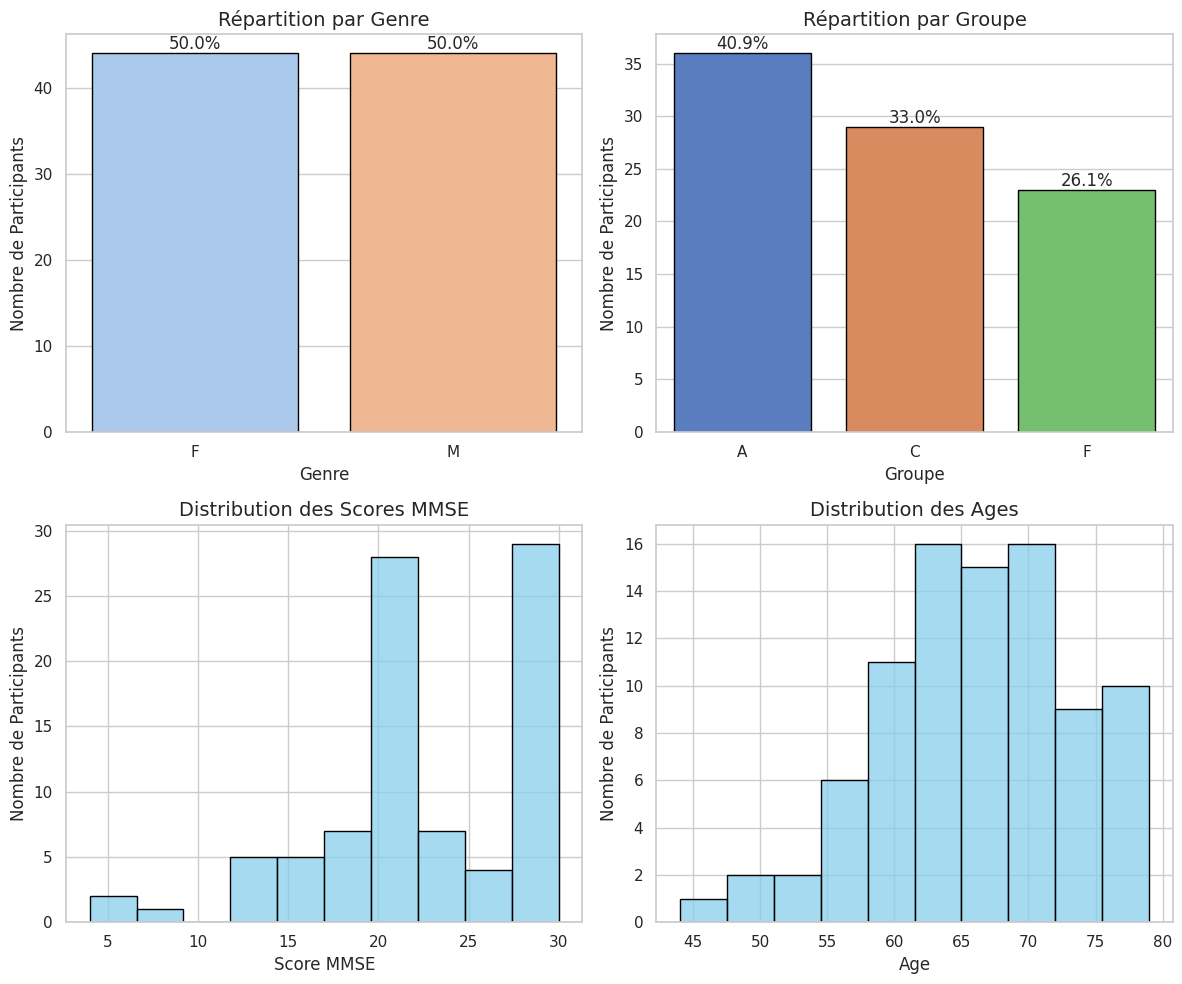

In [3]:
# On va chercher les données des participans pour des stats
path_dataset = "/content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/"
# /content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/participants.tsv
participants_data = pd.read_csv(path_dataset+"participants.tsv", sep='\t')
participants_data.head()

# Appliquer un style Seaborn
sns.set(style="whitegrid")

# Définir la taille de la figure et créer des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme des genres
sns.countplot(ax=axes[0, 0], data=participants_data, x='Gender', palette='pastel', edgecolor='black')
axes[0, 0].set_title('Répartition par Genre', fontsize=14)
axes[0, 0].set_xlabel('Genre', fontsize=12)
axes[0, 0].set_ylabel('Nombre de Participants', fontsize=12)

# Ajouter les pourcentages au-dessus des barres
total = len(participants_data['Gender'])
for p in axes[0, 0].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 0].annotate(percentage, (x, y), ha='center', va='bottom')

# Histogramme des groupes A, C, F
sns.countplot(ax=axes[0, 1], data=participants_data, x='Group', palette='muted', edgecolor='black')
axes[0, 1].set_title('Répartition par Groupe', fontsize=14)
axes[0, 1].set_xlabel('Groupe', fontsize=12)
axes[0, 1].set_ylabel('Nombre de Participants', fontsize=12)

# Ajouter les pourcentages au-dessus des barres
total = len(participants_data['Group'])
for p in axes[0, 1].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 1].annotate(percentage, (x, y), ha='center', va='bottom')

# Histogramme des scores MMSE
sns.histplot(ax=axes[1, 0], data=participants_data, x='MMSE', bins=10, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Distribution des Scores MMSE', fontsize=14)
axes[1, 0].set_xlabel('Score MMSE', fontsize=12)
axes[1, 0].set_ylabel('Nombre de Participants', fontsize=12)

# Histogramme des Ages
sns.histplot(ax=axes[1, 1], data=participants_data, x='Age', bins=10, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Distribution des Ages', fontsize=14)
axes[1, 1].set_xlabel('Age', fontsize=12)
axes[1, 1].set_ylabel('Nombre de Participants', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# ========================================
# ==== Creation des jeux de donnees ===========
# ========================================

import mne
import torch
import numpy as np
import pandas as pd
# get all speech
# contenir des listes des 19 canaux pour les 88 patient
all_spectres = []
all_spectres_canal = []
#all_phases = []


# les raw des patients
liste_de_rats = []

# pour les echantillonnages
all_wav_patient = []
all_fs_patient = []

path_dataset = "/content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/derivatives/"
# path_dataset = "/content/drive/MyDrive/MSLP/Project/Projet_Session-EEG-Alza/derivatives/"
# raw_path = path_dataset + "/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"

files = os.listdir(path_dataset)
for i, fl in enumerate(files):
  # les fichier EEG .set avec mne
  raw = mne.io.read_raw_eeglab(path_dataset+fl+"/eeg/"+fl+"_task-eyesclosed_eeg.set",preload=True)

  # (n_channels x n_samples)
  data, times = raw.get_data(return_times=True)
  channels = raw.ch_names

  # Créer un DataFrame pandas pour liste_de_rats
  df = pd.DataFrame(data.T, columns=channels)  #(n_times, n_channels)
  df['time'] = times  # Ajout du temps
  liste_de_rats.append(df)
  # ========================================
  # liste pour les spectre et phase des canaux
  all_spectrogrames_canal = []
  all_spectrogrames_canal_individuel = []
  #all_phases_canal = []

  # param pour les spectre et phase
  n_fft = 1024
  hop_length = 256
  window = torch.hamming_window(n_fft)
  # pour chaque canal - 19 -  dans le data
  for c in data:
    # wav en tenseur PyTorch
    wav = torch.tensor(c, dtype=torch.float32)

    # spectrogramme d'amplitude
    # transformée de Fourier [Décalage entre les fenetres: hop_length=256]
    wav_stft_comp = torch.stft(wav, n_fft=1024, window=torch.hamming_window(1024), return_complex=True, hop_length=256)
    #wav_stft_phase = wav_stft_comp.angle()
    wav_stft = wav_stft_comp.abs() # abs pour seulement les amplitude / pas de phase

    # prendre le « log(x + 1)
    wav_stft = torch.log1p(wav_stft)
    #all_phases_canal.append(wav_stft_phase.squeeze())
    all_spectrogrames_canal.append(wav_stft.squeeze())
    all_spectrogrames_canal_individuel.append(wav_stft)
  # on va prendre torch.cat
  all_spectrogrames_canal = torch.cat(all_spectrogrames_canal, dim=1).transpose(0, 1)
  #all_phases_canal = torch.cat(all_phases_canal, dim=1).transpose(0, 1)

  print("all_spectrogrames_canal",all_spectrogrames_canal.shape)
  #print("all_phases_canal",all_phases_canal.shape)

  all_spectres.append(all_spectrogrames_canal)
  all_spectres_canal.append(all_spectrogrames_canal_individuel)
  #all_phases.append(all_phases_canal)

  print("all_spectres",len(all_spectres))
  print("all_spectres_canal",len(all_spectres_canal))
  #print("all_phases", len(all_phases))


In [50]:
# information sur les datas produit
print("all_spectres",len(all_spectres))
# Shape de un spectre
print(" shape pour 1 patient 87",all_spectres[87].shape)
# un patient avec 19 spectre
print("all_spectres_canal",len(all_spectres_canal[87]))
print("all_spectres_canal patient 87 canal 5",all_spectres_canal[87][5].shape)
print(liste_de_rats[0].shape)
#print(liste_de_rats)

all_spectres 88
 shape pour 1 patient 87 torch.Size([34162, 513])
all_spectres_canal 19
all_spectres_canal patient 87 canal 5 torch.Size([513, 1798])
(449350, 20)


In [ ]:
# Petit prétraitement des données
# Analyse et prétraitement des données
# On a deux datasets :
#     participants_data -> info sur les participants
#         liste_de_rats -> les eeg des participants

# ======= Rajout de la colonne Classe : 0-1 ou 0-1-2 =============
# 0 - 1 - 1
participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 1})
# 0 - 1 - 2
#participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 2})
#print(participants_data['Class_norm_anorm'])

df_risque_train = participants_data
# info() sur les dataset et les données
print(df_risque_train.info())
# ==============================
# voir le debalancement des classes pour l'entrainement
print(df_risque_train['Class_norm_anorm'].value_counts())

# Affichage nombre de classes par catégorie 0-1
def distribution_bar(ax, df, titre):
    nbr_classe = df['Class_norm_anorm'].value_counts().sort_index()
    ax.bar(nbr_classe.index.astype(str), nbr_classe.values)
    ax.set_xlabel("Classe")
    ax.set_ylabel("Nombre d'échantillons")
    ax.set_title(titre)

# Affichage nombre de classes par catégorie 0-1
def distribution_pie(ax, df, titre):
    nbr_classe = df['Class_norm_anorm'].value_counts().sort_index()
    ax.pie(nbr_classe, labels=nbr_classe.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(titre)
# ==============================
# Visualisation du debalancement de classe
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
distribution_bar(axs[0], df_risque_train, "Distribution des classes Normales - Abnormales")
# graphique pour pie
distribution_pie(axs[1], df_risque_train, "Distribution des classes Normales - Abnormales")
plt.tight_layout()
plt.show()

In [14]:
df_risque_train['Class_norm_anorm'][40]

0


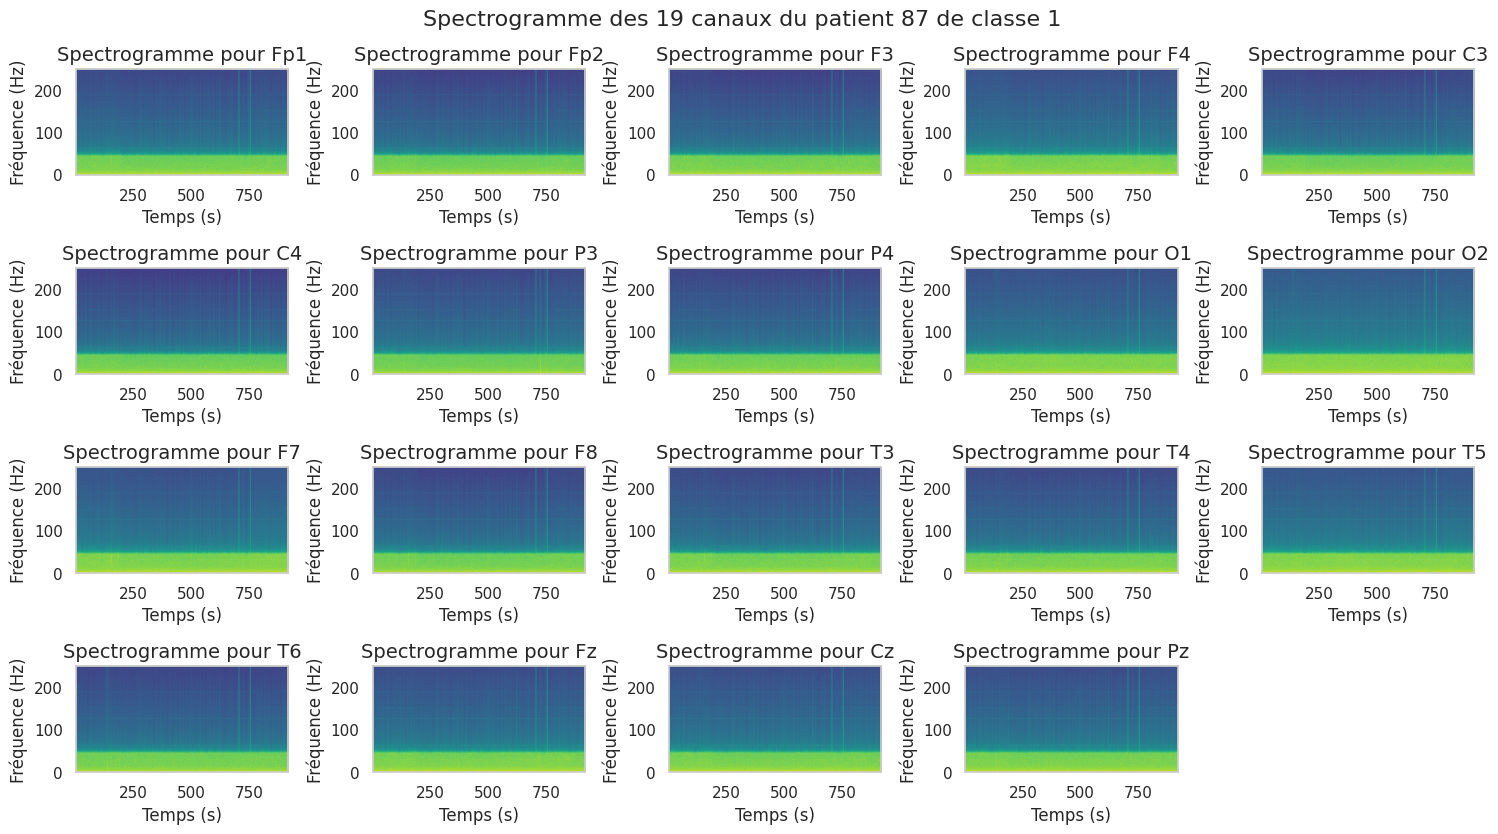

In [16]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram

liste_cmap_col = ['plasma', 'inferno', 'magma', 'cividis', 'Blues', 'Greens', 'Oranges', 'Purples', 'YlGn', 'YlOrBr', 'viridis' ]
couleur = random.choice(liste_cmap_col)

plt.figure(figsize=(15, 10))
num_rows = 5
num_cols = 5
num_subplots = num_rows * num_cols

patient = 87

for i in range(19):
  # Extraction d'un xcanal
  channel_idx = i  # les canaux
  data = liste_de_rats[patient][raw.ch_names[channel_idx]].values
  sfreq = raw.info['sfreq']  # fs
  n_fft = 1024  # fenêtre FFT
  # graphe 5 X 4
  plt.subplot(num_rows, num_cols, i + 1)

  # spectrogramme
  freq, times, Sxx = spectrogram(data, fs=sfreq, nperseg=n_fft)
  plt.imshow(10 * np.log10(Sxx), aspect='auto', origin='lower',
           extent=[times[0], times[-1], freq[0], freq[-1]], cmap='viridis')

  plt.title(f"Spectre pour canal {i}")
  plt.xlabel('Temps (s)', fontsize=12)
  plt.ylabel('Fréquence (Hz)', fontsize=12)
  plt.title(f'Spectrogramme pour {channels[channel_idx]}', fontsize=14)
  plt.grid(False)
plt.suptitle(f"Spectrogramme des 19 canaux du patient {patient} de classe {df_risque_train['Class_norm_anorm'][patient]}", fontsize=16)
plt.tight_layout()
plt.show()

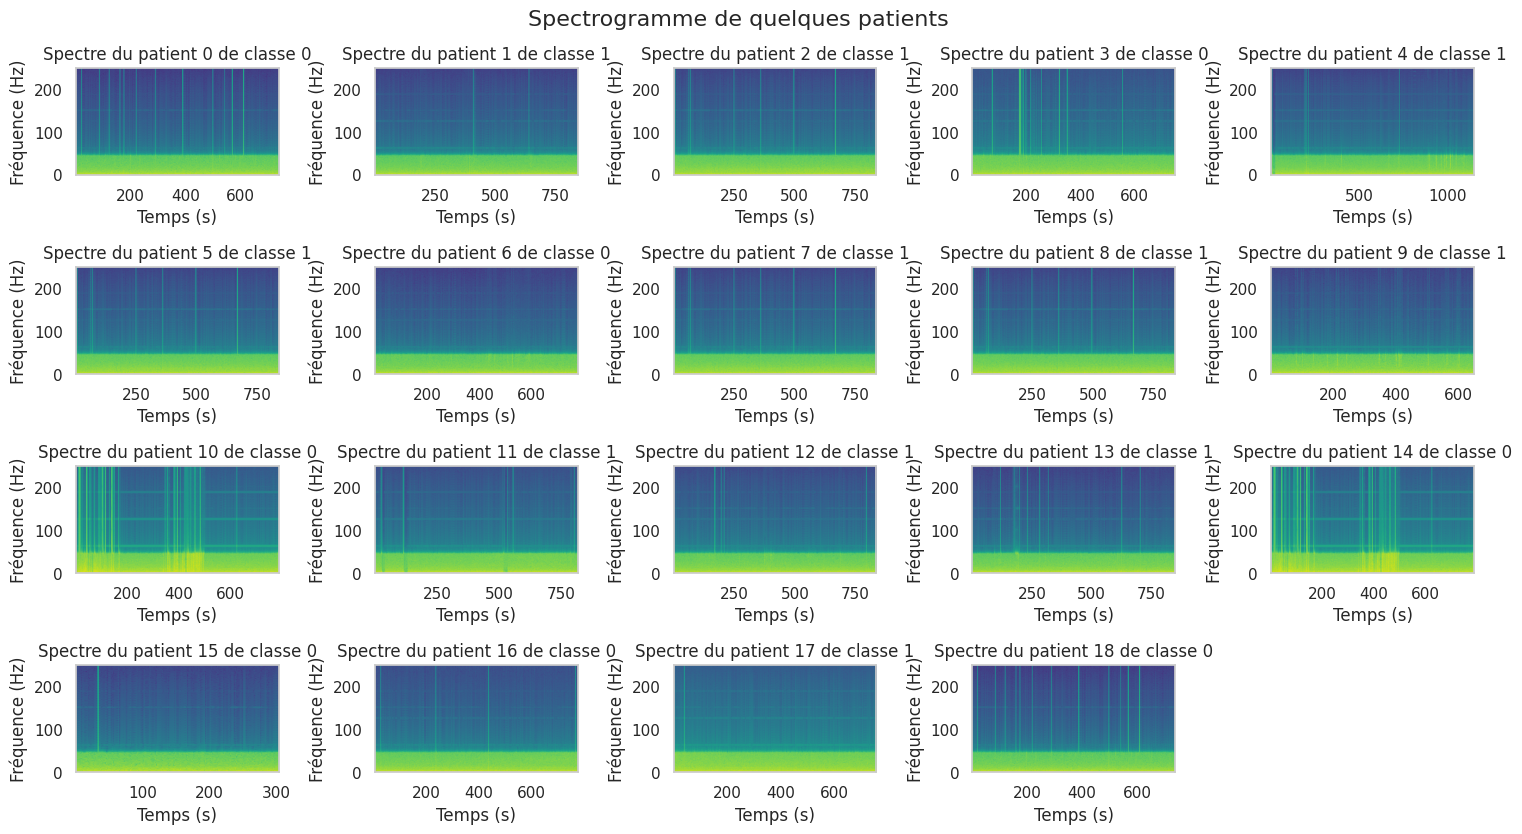

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

plt.figure(figsize=(15, 10))

num_rows = 5
num_cols = 5

num_subplots = num_rows * num_cols

for i in range(19):
  patient = random.randint(0, 87)
  data = liste_de_rats[patient]
  all_canaux = np.mean([data[raw.ch_names[k]].values for k in range(19)], axis=0)

  sfreq = raw.info['sfreq']  # fs
  n_fft = 1024  # fenêtre FFT

  # spectrogramme total
  freq, times, Sxx = spectrogram(all_canaux, fs=sfreq, nperseg=n_fft)
  spectrogram_tensor = np.log1p(random.choice(all_spectres))
  spectrogram_tensor = np.log1p(spectrogram_tensor)
  # graphe 5 x 4
  plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(10 * np.log10(Sxx), aspect='auto', origin='lower',
           extent=[times[0], times[-1], freq[0], freq[-1]], cmap='viridis')
  plt.title(f"Spectre du patient {i} de classe {df_risque_train['Class_norm_anorm'][patient]}")
  plt.xlabel('Temps (s)', fontsize=12)
  plt.ylabel('Fréquence (Hz)', fontsize=12)
  plt.grid(False)
plt.suptitle(f"Spectrogramme de quelques patients ", fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-18-6f85237dc737>:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


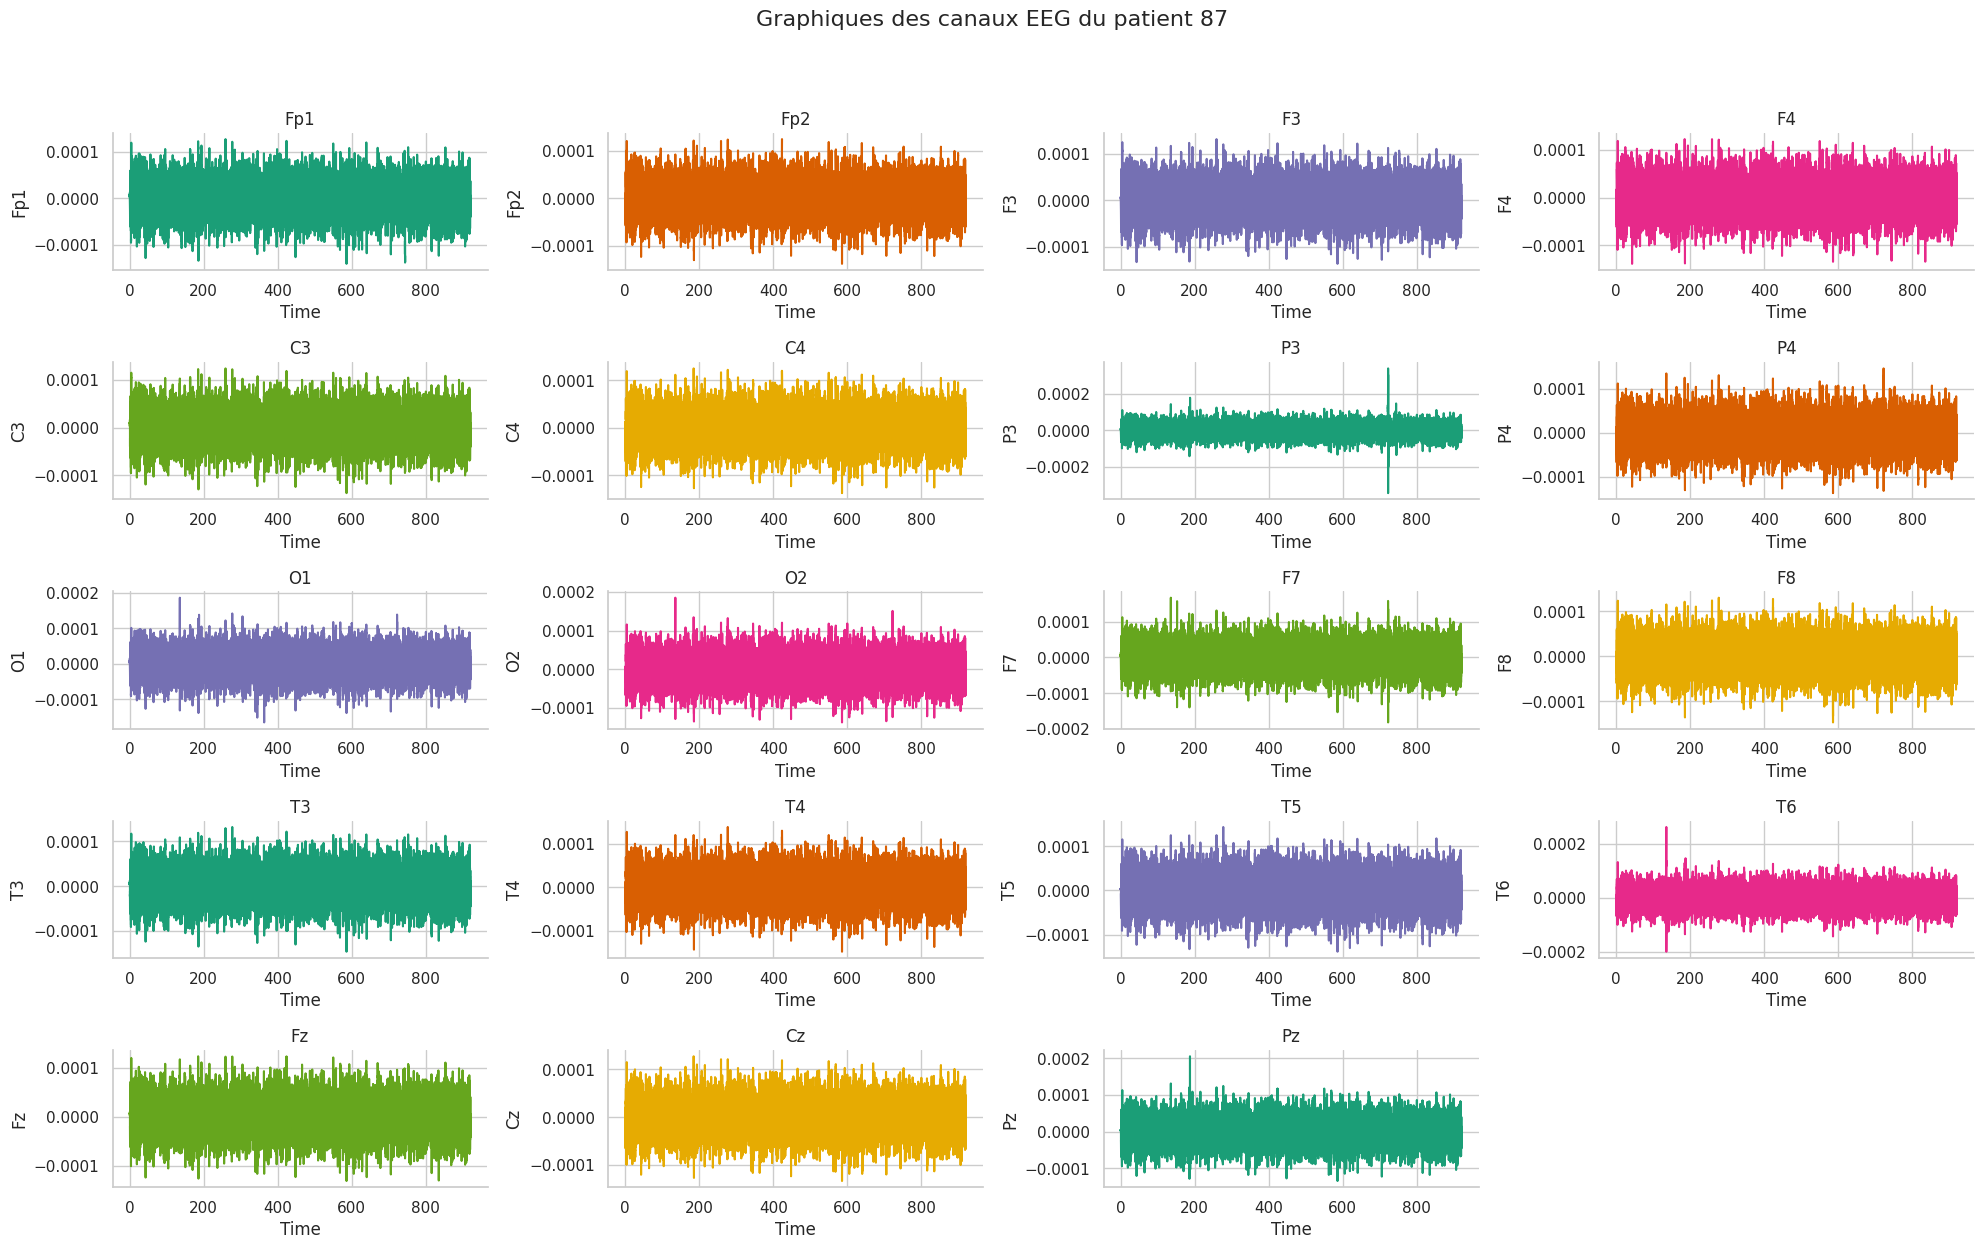

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

patient = 87

# df [0][
# couleur
palette = list(sns.palettes.mpl_palette('Dark2'))
#  canal EEG
def _plot_series(ax, series, series_name, series_index=0):
    xs = series['time']
    ys = series[series_name]
    ax.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])
    ax.set_xlabel('Time')
    ax.set_ylabel(series_name)
    ax.set_title(series_name)

#  6 lignes et 4 colonnes de sous-graphiques
fig, axes = plt.subplots(6, 4, figsize=(20, 15), layout='constrained')
# graphe
for i, feature in enumerate(raw.ch_names):
    row = i // 4
    col = i % 4
    _plot_series(axes[row, col], liste_de_rats[87], feature, series_index=i)
    sns.despine(fig=fig, ax=axes[row, col])

for j in range(len(raw.ch_names), 24):
    fig.delaxes(axes[j // 4, j % 4])

u = 87  # choix de patients 0-87
fig.suptitle(f"Graphiques des canaux EEG du patient {u}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Implementation Guido Higging face

In [19]:
"""
Fonction pour mettre tout le dataset sur le même nombre d'échantillons
"""
import torch
import pandas as pd
import numpy as np
# Data generator for on-the-fly padding
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, dataframes, max_rows, max_cols):
        self.dataframes = dataframes
        self.max_rows = max_rows
        self.max_cols = max_cols

    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, idx):
        # Pad the DataFrame for the given index
        df = self.dataframes[idx]
        array = df.values
        padded_array = np.pad(
            array,
            pad_width=((0, self.max_rows - array.shape[0]), (0, self.max_cols - array.shape[1])),
            mode='constant',
            constant_values=0
        )
        # Convert to tensor
        tensor = torch.tensor(padded_array, dtype=torch.float32)

        return tensor

In [20]:
# =========== Creation des données de test et de trains
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ========== pour la fonction EEGDataset================
labels = torch.tensor(participants_data['Class_norm_anorm'],dtype=torch.long)

# Determine the maximum number of rows (time samples)
max_rows = max(df.shape[0] for df in liste_de_rats)
max_cols = liste_de_rats[0].shape[1]  # Assuming consistent channels

# Create the dataset and DataLoader
# Jeu de donnes pour les entrainement
eeg_tensor = EEGDataset(liste_de_rats, max_rows, max_cols)
labels_tensor = EEGDataset(participants_data['Class_norm_anorm'].values , max_rows, max_cols)

print(f"EEG Tensor Shape: {len(eeg_tensor)}")
print(f"Labels Tensor Shape: {len(labels_tensor)}")

# ==== Transformation des datas =============================
# Get all data from the dataset as a NumPy array
X = np.array([eeg_tensor[i].numpy() for i in range(len(eeg_tensor))])
print("X", X.shape)
# Reshape to Input : [batch_size, channels, time_steps]
# 19 channels + 1 time column
X = X[:, :, :-1]
print("X [batch_size, channels, time_steps] : ", X.shape)
# Reshape to (batch_size, channels, time_steps)
X = X.reshape(X.shape[0], 19, -1)
print("X sans time ", X.shape)
# Assuming dataset is a 3D array: (n_samples, n_channels, n_features)
scaler = StandardScaler()
# Reshape to 2D for scaling
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1))
print("X_scaled", X_scaled.shape)
# Reshape back to 3D after scaling
dataset_scaled = X_scaled.reshape(X.shape[0], 19, -1)
print("dataset_scaled", dataset_scaled.shape)

# Train et dataset
# Convert the PyTorch tensor to a NumPy array

# Split the data using NumPy arrays
X_train, X_test, y_train, y_test = train_test_split(dataset_scaled, labels, test_size=0.20, random_state=42)
print("=====================numpy========================")
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

EEG Tensor Shape: 88
Labels Tensor Shape: 88
X (88, 640860, 20)
X [batch_size, channels, time_steps] :  (88, 640860, 19)
X sans time  (88, 19, 640860)
X_scaled (88, 12176340)
dataset_scaled (88, 19, 640860)
=====================numpy========================
X_train (70, 19, 640860)
y_train torch.Size([70])
X_test (18, 19, 640860)
y_test torch.Size([18])


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Paramètres
n_times = 128
stride = 64   # Décalage entre segments

# Fonction pour segmenter les données
def segment_data(data, n_times, stride):
    n_patients, n_channels, n_points = data.shape
    segments = []
    for patient in range(n_patients):
        for start in range(0, n_points - n_times + 1, stride):
            segment = data[patient, :, start:start + n_times]
            segments.append(segment)
    return np.array(segments)

# dataset train segment
dataset_segments_train = segment_data(X_train, n_times=n_times, stride=stride)
print("Format des segments train :", dataset_segments_train.shape)

y_labels_train = np.array(y_train)
# Classes
labels_train = np.repeat(y_labels_train, dataset_segments_train.shape[0] // len(y_labels_train))
print("Format des étiquettes train :", labels_train.shape)

# dataset test segment
dataset_segments_test = segment_data(X_test, n_times=n_times, stride=stride)
print("Format des segments test :", dataset_segments_test.shape)

y_labels_test = np.array(y_test)
# Classes
labels_test = np.repeat(y_labels_test, dataset_segments_test.shape[0] // len(y_labels_test))
print("Format des étiquettes test :", labels_test.shape)


Format des segments train : (700840, 19, 128)
Format des étiquettes train : (700840,)
Format des segments test : (180216, 19, 128)
Format des étiquettes test : (180216,)


In [44]:
# upsampling de classes
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
# compte de classes
class_counts = np.bincount(labels_train)
class_counts_ = np.bincount(labels_test)
# compte les occurences de chaque classe
class_weights = 1 / class_counts
class_weights_ = 1 / class_counts_

# calcul des poids
sample_weights = class_weights[labels_train]
sample_weights_ = class_weights_[labels_test]

# Creation des samples
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
sampler_ = WeightedRandomSampler(weights=sample_weights_, num_samples=len(sample_weights_), replacement=True)

# Datalaoder test et train
# données en tenseurs PyTorch
# DataLoader train
batch_size = 16
X = torch.tensor(dataset_segments_train, dtype=torch.float32)
y = torch.tensor(labels_train, dtype=torch.long)
dataloader_train = DataLoader(TensorDataset(X, y), batch_size=batch_size, sampler=sampler, pin_memory=True)

print("Taille du DataLoader train :", len(dataloader_train))

# DataLoader test
# données en tenseurs PyTorch
X = torch.tensor(dataset_segments_test, dtype=torch.float32)
y = torch.tensor(labels_test, dtype=torch.long)

dataset = TensorDataset(X, y)
dataloader_test = DataLoader(TensorDataset(X, y), batch_size=batch_size, sampler=sampler_, pin_memory=True)

print("Taille du DataLoader test :", len(dataloader_test))


Taille du DataLoader train : 43803
Taille du DataLoader test : 11264


In [45]:
# Code test pour voir les dataloader
# Data train
print('datalodataloader_train ')
for i, l in dataloader_train:
  print('I batch dimensions:', i.size())
  print('L label dimensions:', l.size())
  print(l[:16])
  break
print(len(dataloader_train))

# Data test
print('datalodtest: ')
for i, l in dataloader_test:
  print('I batch dimensions:', i.size())
  print('L label dimensions:', l.size())
  print(l[:16])
  break

print(len(dataloader_test))

datalodataloader_train 
I batch dimensions: torch.Size([16, 19, 128])
L label dimensions: torch.Size([16])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])
43803
datalodtest: 
I batch dimensions: torch.Size([16, 19, 128])
L label dimensions: torch.Size([16])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0])
11264


In [29]:
%%capture
!pip install braindecode

In [30]:
# ======================================
# https://huggingface.co/guido151/EEGNetv4
# ======================================
from braindecode.models import EEGNetv4
from huggingface_hub import hf_hub_download
from skorch import NeuralNet
import torch.nn as nn
import torch as th
import torch
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
# fichiers pour initialiser et charger le modele pretrain
path_params = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/params.pt',)
path_optimizer = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/optimizer.pt',)
path_history = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/history.json',)
path_criterion = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/criterion.pt',)

model = EEGNetv4(n_chans=19,
                 n_outputs=2,
                 n_times=128,)

net = NeuralNet(model, criterion=nn.CrossEntropyLoss(weight=th.tensor([1, 1])),)
net.initialize()
net.load_params(path_params,
                path_optimizer,
                path_criterion,
                path_history,)

def get_fid_model(model: EEGNetv4) -> nn.Module:
    fid_model = deepcopy(model)
    for i in range(len(fid_model)):
        if i >= 14:
            fid_model[i] = Identity()
    fid_model.eval()
    for param in fid_model.parameters():
        param.requires_grad = False
    return fid_model

def get_is_model(model: EEGNetv4) -> nn.Module:
    is_model = deepcopy(model)
    is_model.eval()
    for param in is_model.parameters():
        param.requires_grad = False
    return is_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


params.pt:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

history.json:   0%|          | 0.00/35.5M [00:00<?, ?B/s]

criterion.pt:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/skorch/net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)


In [46]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialisation du modèle
model = EEGNetv4(n_chans=19, n_outputs=2, n_times=128)
model.to(device)
# Initialisation avec le param beta
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
from torch.optim import Adam

# Initialisation du modèle
model = EEGNetv4(n_chans=19, n_outputs=2, n_times=128)
model.to(device)
# Initialisation avec le param beta
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Chargement des poids uniquement
model.load_state_dict(torch.load(path_params, map_location=torch.device('cpu')))
criterion.weight = criterion.weight.to(device)

Using device: cuda


<ipython-input-46-f2bca06dfc76>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_params, map_location=torch.device('cpu')))


In [47]:
# Initialiser le modèle pour l'entraînement
model.train()

# Boucle d'entraînement
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in dataloader_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # les metriques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / len(dataloader_train)
    train_accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch 1/50 - Loss: 0.6170, Accuracy: 65.72%
Epoch 2/50 - Loss: 0.5835, Accuracy: 68.61%
Epoch 3/50 - Loss: 0.5635, Accuracy: 70.46%
Epoch 4/50 - Loss: 0.5554, Accuracy: 71.14%
Epoch 5/50 - Loss: 0.5494, Accuracy: 71.66%
Epoch 6/50 - Loss: 0.5441, Accuracy: 71.98%
Epoch 7/50 - Loss: 0.5401, Accuracy: 72.35%
Epoch 8/50 - Loss: 0.5370, Accuracy: 72.58%
Epoch 9/50 - Loss: 0.5342, Accuracy: 72.71%
Epoch 10/50 - Loss: 0.5317, Accuracy: 72.92%
Epoch 11/50 - Loss: 0.5299, Accuracy: 73.05%
Epoch 12/50 - Loss: 0.5276, Accuracy: 73.12%
Epoch 13/50 - Loss: 0.5267, Accuracy: 73.18%
Epoch 14/50 - Loss: 0.5252, Accuracy: 73.40%
Epoch 15/50 - Loss: 0.5236, Accuracy: 73.57%
Epoch 16/50 - Loss: 0.5226, Accuracy: 73.57%
Epoch 17/50 - Loss: 0.5204, Accuracy: 73.61%
Epoch 18/50 - Loss: 0.5181, Accuracy: 73.95%
Epoch 19/50 - Loss: 0.5187, Accuracy: 73.89%
Epoch 20/50 - Loss: 0.5166, Accuracy: 73.97%
Epoch 21/50 - Loss: 0.5160, Accuracy: 74.10%
Epoch 22/50 - Loss: 0.5163, Accuracy: 74.08%
Epoch 23/50 - Loss:

In [49]:
# Évaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in dataloader_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f"Précision sur le test set : {100 * correct / total:.2f}%")

Précision sur le test set : 47.21%
